# How to Run this Jupyter Notebook

1. Open Coppelia
2. Install the zeroMQ API
3. Install the modules used in this notebook
4. Put the path of the folder scenes in the cell below

In [47]:
scenesFolder = "/Users/raphaHausen/Class_Mobile_Robots/TP1/scenes"

# Core Components

This core components contains the tools we're using for the assignment. It shows how to use Coppelia for our project and describes some basic functions. These functions help us draw graphs and figure out where one object is in relation to another.

## Modules Used

In [48]:
# Modules used to connect to coppelia
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

In [49]:
# Other Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tabulate import tabulate
import os

## How to Connect to Coppelia

In [50]:
# An exemple of how to use the api to connet to coppelia
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(True)

sim.startSimulation()
# DO SOME STUFF
sim.stopSimulation()

## Function Used in this Assignment

### Function used for plotting

In [51]:
# Apenas para visualização de um referencial no plano
def plot_frame(Porg, R, c=['r', 'g']):
    
    axis_size = 3.0    
    axes = axis_size*R
    
    x_axis = np.array(axes[0:2,0])
    y_axis = np.array(axes[0:2,1])
        
    # X
    plt.quiver(*Porg[:2], *x_axis, color=c[0], angles='xy', scale_units='xy', scale=1)
    
    # Y
    plt.quiver(*Porg[:2], *y_axis, color=c[1], angles='xy', scale_units='xy', scale=1)

In [52]:
# Realiza o plot de um frame
# A visualização plota 3 referencias
# E a direção das tranformações realizadas 
# Para representar uma posição em outro referencial
def plot3CompostTransformation(middleMatrix, destMatrix):
    # Objetivo: Tranformar um ponto no referencial C
    #           Para o referencial B
    #           E finalmente para o referencial A
    
    # Origem do referencial A
    aorg = np.array([0, 0])
    

    # Define Tbc
    # Que transforma um ponto no referencial C
    # Para o referencial B
    Tbc = destMatrix
    pb_corg = Tbc[0:3, 3]
    Rbc = Tbc[:3,:3]

    # Define Tab
    # Que transforma um ponto no referencial B
    # Para o referencial A
    Tab = middleMatrix
    pa_borg = Tab[:3, 3]
    Rab = Tab[:3,:3]
    
    # Calcula Tac
    # Que transforma um ponto no referencial C
    # Para o referencial A
    Tac = Tab @ Tbc
    
    # A origem de C em relação a A
    pa_corg = np.array(Tac[:,3])
    ## Vector from the origin B to origin C from the perpective of A
    pb_corg_aux = Rab @ pb_corg
    Rac = Tac[:3,:3]
    ## plot the C axis origin and the vector from the B axis to C axis
    plot_frame(pa_corg, Rac, ['g', 'g'])
    plt.quiver(*pa_borg[:2], *pb_corg_aux[:2], color='g', angles='xy', scale_units='xy', scale=1)

    # Plot the B origin and the vector from A origin to B origin
    plot_frame(pa_borg, Rab, ['b', 'b'])
    plt.quiver(*aorg, *pa_borg[:2], color='b', angles='xy', scale_units='xy', scale=1)

    plt.axis('scaled')
    plt.axis((-15, 15, -15, 15))
    

### Codding to calculate the Transformation Matrix

In [53]:
# Function that invert a matrix
def invertMatrix(M):
    return np.linalg.inv(M)

In [54]:
# Get Object Position and Orientation
def getPositionAndOrientation(handle, referenceTo):
    pos = sim.getObjectPosition(handle, referenceTo)
    ori = sim.getObjectOrientation(handle, referenceTo)
    return pos, ori

In [55]:
# Get Rotation Matrix fixed on Z axis
def getRotationMatrixZfixed(theta):
    return np.array([[  np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta),  np.cos(theta), 0 ],
                      [ 0            ,  0            , 1 ]])

In [56]:
# get the transformation from local axis to a reference axis
# the default reference axis is the global/world axis
def getTransformationMatrix(handle, referenceTo=sim.handle_world):
    # Get the object position and orientation
    pos, ori = getPositionAndOrientation(handle, referenceTo)
    # Get the Rotation Matrix
    rotM = getRotationMatrixZfixed(ori[2])
    scale = np.array([0, 0, 0, 1])

    # Create the transformation Matrix
    tranfMatrix = np.column_stack((rotM, pos))
    tranfMatrix = np.row_stack((tranfMatrix, scale))

    return tranfMatrix



In [57]:
# Get the tranfortion from object in reference to another
def getTransformationMatrixObject2Object(sourceObject, desObject,printPlot = False):
    M_S2G = getTransformationMatrix(sourceObject)
    M_G2S = invertMatrix(M_S2G)
    M_D2G = getTransformationMatrix(desObject)

    if printPlot:
        plot3CompostTransformation(M_G2S, M_D2G)

    return M_G2S @ M_D2G

# Assignment Exercise

## Exercise 2

Segue abaixo o diagrama que representa o sistema de coordenadas e transformações entre os objetos.

- W -> Mundo (World)
- T -> Árvore (Tree)
- K -> Estante (Rack)
- C -> Cadeira (Chair)
- D -> Mesa (Table)
- P -> Pessoa (Person)
- R -> Robô (Robot)

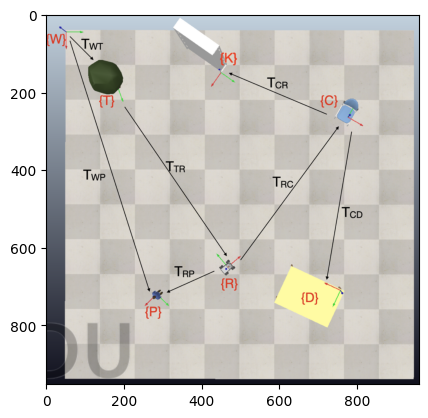

In [58]:
plt.imshow(mpimg.imread('diagrama.png'))

## Exercise 3
Para executar, passe o caminho do arquivo scene.ttt na pasta 3 para a função e rode as celulas a seguir.

In [59]:
def plotReferencial(scenePath):
    # Open the scene
    sim.loadScene(scenePath+"@keepCurrent")
    sim.startSimulation()

    # Get Objects Handle
    personHandle = sim.getObject("/Rapha")
    chairHandle = sim.getObject("/Chair")
    treeHandle = sim.getObject("/Tree")
    diningTableHandle = sim.getObject("/diningTable")
    rackHandle = sim.getObject("/Rack")
    robotHanle = sim.getObject("/Robot")

    # Get transformation Matriz from local to a object reference
    result = getTransformationMatrixObject2Object(robotHanle, personHandle, printPlot = True)
    print("Person position from robot pov:")
    print(tabulate(result, tablefmt="heavy_grid"))
    result = getTransformationMatrixObject2Object(robotHanle, chairHandle, printPlot = True)
    print("Chair position from robot pov:")
    print(tabulate(result, tablefmt="heavy_grid"))
    result = getTransformationMatrixObject2Object(robotHanle, treeHandle, printPlot = True)
    print("Tree position from robot pov:")
    print(tabulate(result, tablefmt="heavy_grid"))
    result = getTransformationMatrixObject2Object(robotHanle, diningTableHandle, printPlot = True)
    print("Dining table position from robot pov:")
    print(tabulate(result, tablefmt="heavy_grid"))
    result = getTransformationMatrixObject2Object(robotHanle, rackHandle, printPlot = True)
    print("Rack position from robot pov:")
    print(tabulate(result, tablefmt="heavy_grid"))

    sim.stopSimulation()

    while sim.getSimulationState() != sim.simulation_stopped:
        sim.step()
    sim.closeScene()

Person position from robot pov:
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━┳━━━━━━━━━━━┓
┃ -0.99618   ┃  0.0873234 ┃ 0 ┃ -3.88154  ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃ -0.0873234 ┃ -0.99618   ┃ 0 ┃  1.36331  ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0         ┃  0         ┃ 1 ┃ -0.508934 ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0         ┃  0         ┃ 0 ┃  1        ┃
┗━━━━━━━━━━━━┻━━━━━━━━━━━━┻━━━┻━━━━━━━━━━━┛
Chair position from robot pov:
┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━┳━━━━━━━━━━━┓
┃ -0.941143 ┃  0.33801  ┃ 0 ┃ 10.7749   ┃
┣━━━━━━━━━━━╋━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃ -0.33801  ┃ -0.941143 ┃ 0 ┃  2.3823   ┃
┣━━━━━━━━━━━╋━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0        ┃  0        ┃ 1 ┃ -0.295632 ┃
┣━━━━━━━━━━━╋━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0        ┃  0        ┃ 0 ┃  1        ┃
┗━━━━━━━━━━━┻━━━━━━━━━━━┻━━━┻━━━━━━━━━━━┛
Tree position from robot pov:
┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━┳━━━━━━━━━━━┓
┃ -0.939739 ┃ -0.341893 ┃ 0 ┃  1.82515  ┃
┣━━━━━━━━━━━╋━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0.34

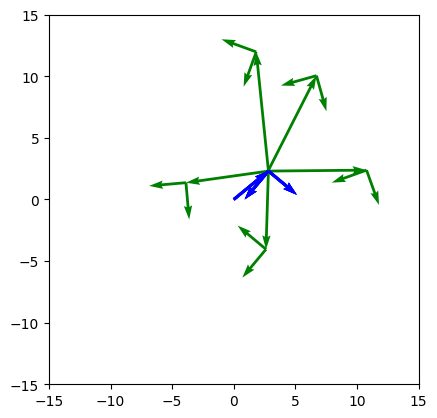

In [60]:
plotReferencial(os.path.join(scenesFolder,"3/scene.ttt"))

## Exercise 4

Cada subseção possui uma cena propria no qual o robo está em uma posição diferente

### 4.1
Para executar, abra a cena scene4.1.ttt na pasta 4 e rode a celula a seguir.

Person position from robot pov:
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━┳━━━━━━━━━━━┓
┃ 0.173482 ┃ -0.984837 ┃ 0 ┃  0.238915 ┃
┣━━━━━━━━━━╋━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃ 0.984837 ┃  0.173482 ┃ 0 ┃ -4.35005  ┃
┣━━━━━━━━━━╋━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃ 0        ┃  0        ┃ 1 ┃ -0.508934 ┃
┣━━━━━━━━━━╋━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃ 0        ┃  0        ┃ 0 ┃  1        ┃
┗━━━━━━━━━━┻━━━━━━━━━━━┻━━━┻━━━━━━━━━━━┛
Chair position from robot pov:
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━┳━━━━━━━━━━━━┓
┃ -0.0829168 ┃ -0.996556  ┃ 0 ┃  -2.57033  ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━╋━━━━━━━━━━━━┫
┃  0.996556  ┃ -0.0829168 ┃ 0 ┃ -18.7707   ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━╋━━━━━━━━━━━━┫
┃  0         ┃  0         ┃ 1 ┃  -0.233094 ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━╋━━━━━━━━━━━━┫
┃  0         ┃  0         ┃ 0 ┃   1        ┃
┗━━━━━━━━━━━━┻━━━━━━━━━━━━┻━━━┻━━━━━━━━━━━━┛
Tree position from robot pov:
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━┳━━━━━━━━━━━━┓
┃ 0.566262 ┃ -0.824226 ┃ 0 ┃   9.12617  ┃
┣━━━━━━━━━━╋━━━━━━━━━━━╋━━━╋━━━━━━━━━━━━┫
┃ 0.824

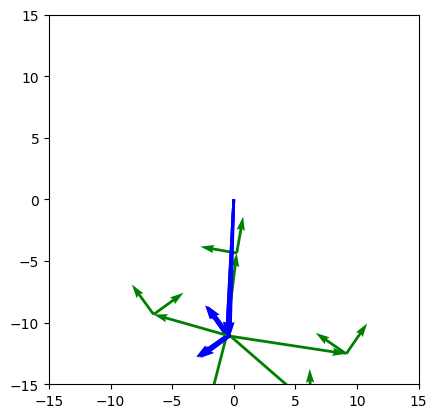

In [61]:
plotReferencial(os.path.join(scenesFolder,"4/scene4.1.ttt"))

### 4.2
Para executar, abra a cena scene4.2.ttt na pasta 4 e rode a celula a seguir.

Person position from robot pov:
┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━┳━━━━━━━━━━━┓
┃ -0.984837 ┃ -0.173482 ┃ 0 ┃ -4.76598  ┃
┣━━━━━━━━━━━╋━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0.173482 ┃ -0.984837 ┃ 0 ┃  6.97839  ┃
┣━━━━━━━━━━━╋━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0        ┃  0        ┃ 1 ┃ -0.508934 ┃
┣━━━━━━━━━━━╋━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0        ┃  0        ┃ 0 ┃  1        ┃
┗━━━━━━━━━━━┻━━━━━━━━━━━┻━━━┻━━━━━━━━━━━┛
Chair position from robot pov:
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━┳━━━━━━━━━━━┓
┃ -0.996401  ┃  0.0847701 ┃ 0 ┃  9.64716  ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃ -0.0847701 ┃ -0.996401  ┃ 0 ┃  4.1874   ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0         ┃  0         ┃ 1 ┃ -0.233094 ┃
┣━━━━━━━━━━━━╋━━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0         ┃  0         ┃ 0 ┃  1        ┃
┗━━━━━━━━━━━━┻━━━━━━━━━━━━┻━━━┻━━━━━━━━━━━┛
Tree position from robot pov:
┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━┳━━━━━━━━━━━┓
┃ -0.824552 ┃ -0.565786 ┃ 0 ┃  3.34677  ┃
┣━━━━━━━━━━━╋━━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0.56

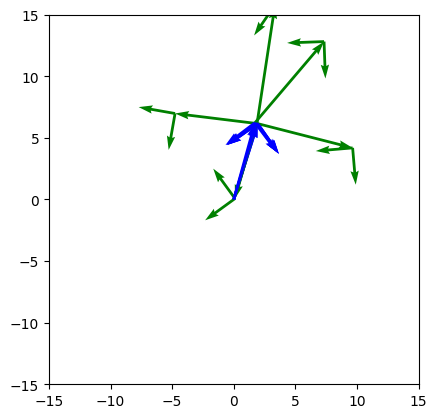

In [62]:
plotReferencial(os.path.join(scenesFolder,"4/scene4.2.ttt"))

### 4.3
Para executar, abra a cena scene4.3.ttt na pasta 4 e rode a celula a seguir.

Person position from robot pov:
┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━┳━━━━━━━━━━━┓
┃  0.573669 ┃ 0.819087 ┃ 0 ┃  9.57864  ┃
┣━━━━━━━━━━━╋━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃ -0.819087 ┃ 0.573669 ┃ 0 ┃ -0.672454 ┃
┣━━━━━━━━━━━╋━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0        ┃ 0        ┃ 1 ┃ -0.495445 ┃
┣━━━━━━━━━━━╋━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0        ┃ 0        ┃ 0 ┃  1        ┃
┗━━━━━━━━━━━┻━━━━━━━━━━┻━━━┻━━━━━━━━━━━┛
Chair position from robot pov:
┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━┳━━━━━━━━━━━┓
┃  0.763303 ┃ 0.646041 ┃ 0 ┃  1.36802  ┃
┣━━━━━━━━━━━╋━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃ -0.646041 ┃ 0.763303 ┃ 0 ┃ 11.5111   ┃
┣━━━━━━━━━━━╋━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0        ┃ 0        ┃ 1 ┃ -0.233094 ┃
┣━━━━━━━━━━━╋━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃  0        ┃ 0        ┃ 0 ┃  1        ┃
┗━━━━━━━━━━━┻━━━━━━━━━━┻━━━┻━━━━━━━━━━━┛
Tree position from robot pov:
┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━┳━━━━━━━━━━━┓
┃  0.175373 ┃ 0.984502 ┃ 0 ┃ -2.46581  ┃
┣━━━━━━━━━━━╋━━━━━━━━━━╋━━━╋━━━━━━━━━━━┫
┃ -0.984502 ┃ 0.175373 ┃ 0 ┃ -1.04136  ┃
┣━━━━

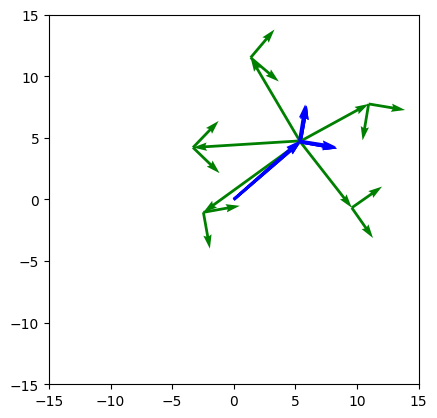

In [63]:
plotReferencial(os.path.join(scenesFolder,"4/scene4.3.ttt"))

## Exercise 5
Para executar, abra a cena scene5.ttt na pasta 5 e rode as celulas a seguir.

### Define Functions

#### Get Data from the sensor

In [64]:
'''
readSensorData - It will try to capture the range and angle data from the simulator.
                 The request for the range data is sent in streaming mode to force
                 it to sync with the angle data request which acts as a mutex.

inputs:
    -clientId: simulator client id obtained through a successfull connection with the simulator.
    -range_data_signal_id: string containing the range data signal pipe name.
    -angle_data_signal_id: string containing the angle data signal pipe name.
outputs:
    -returns None if no data is recovered.
    -returns two arrays, one with data range and the other with their angles, if data was 
    retrieved successfully.
'''
def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    # returnCodeRanges, string_range_data = sim.getStringSignal(range_data_signal_id, sim.simx_opmode_streaming)
    # returnCodeRanges, string_range_data = sim.getStringSignal(range_data_signal_id)

    # print(range_data_signal_id)
    resultCodeRanges = sim.getStringSignal(range_data_signal_id)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    # returnCodeAngles, string_angle_data = sim.simxGetStringSignal(angle_data_signal_id, sim.simx_opmode_blocking)
    
    resultCodeAngles = sim.getStringSignal(angle_data_signal_id)

    # check the if both data were obtained correctly
    if resultCodeRanges != None and resultCodeAngles != None:
        # unpack data from range and sensor messages
        raw_range_data = sim.unpackFloatTable(resultCodeRanges)
        raw_angle_data = sim.unpackFloatTable(resultCodeAngles)

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None, None


In [65]:
def draw_laser_data(laser_data, max_sensor_range=5, ax = None):
    
    if (ax == None):
        fig = plt.figure(figsize=(6,6), dpi=100)
        ax = fig.add_subplot(111, aspect='equal')
        
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
        # Logo, usar um pequeno limiar do máximo para considerar a leitura
        if (max_sensor_range - dist) > 0.1:
            x = dist * np.cos(ang)
            y = dist * np.sin(ang)
            c = 'r'
            if ang < 0:    
                c = 'b'
            ax.plot(x, y, 'o', color=c)

    ax.plot(0, 0, 'k>', markersize=10)
        
    ax.grid()
    ax.set_xlim([-max_sensor_range, max_sensor_range])
    ax.set_ylim([-max_sensor_range, max_sensor_range])

### Example

In [66]:
import time
def laserPlot(scenePath):
    sim.loadScene(scenePath+"@keepCurrent")
    sim.startSimulation()

    print ('Connected to remote API server')
        
    # Iniciando a simulação
    # Deve usar a porta do 'continuous remote API server services' (remoteApiConnections.txt)
    # e = sim.simxStartSimulation(clientID,sim.simx_opmode_blocking)

    # Handle para o ROBÔ    
    robotname = "/Pioneer_p3dx"
    robotHandle = sim.getObject(robotname)     

    # Handle para as juntas das RODAS
    l_wheel = sim.getObject(robotname + '_leftMotor')
    r_wheel = sim.getObject(robotname + '_rightMotor')    

    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"

    # Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
    # Em loop até garantir que as leituras serão válidas

    range_data = None
    while range_data == None:
        range_data = sim.getStringSignal(laser_range_data)
        sim.step()

    # Prosseguindo com as leituras
    raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
    laser_data = np.array([raw_angle_data, raw_range_data]).T

    draw_laser_data(laser_data)

    pos = sim.getObjectPosition(robotHandle, sim.handle_world)        
    print('Pos: ', pos)

    #raise SystemExit()

    # Dados do Pioneer
    L = 0.381   # Metros
    r = 0.0975  # Metros

    sim.stopSimulation()
    while sim.getSimulationState() != sim.simulation_stopped:
        sim.step()
    sim.closeScene()
        
    print ('Program ended')

Connected to remote API server
Pos:  [-6.618485221470176, -5.025158745759126, 0.4386447836064624]
Program ended


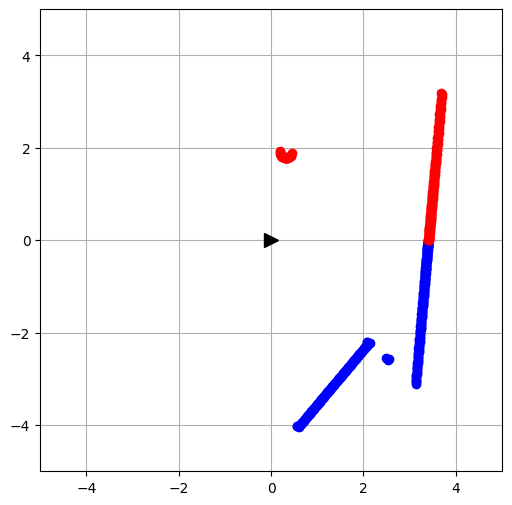

In [67]:
laserPlot(os.path.join(scenesFolder,"5/scene5.ttt"))

### 5.1
Para executar, abra a cena scene5.1.ttt na pasta 5 e rode a celula a seguir.

Connected to remote API server
Pos:  [4.781351063002128, 3.4251008588960064, 0.43864971442516704]
Program ended


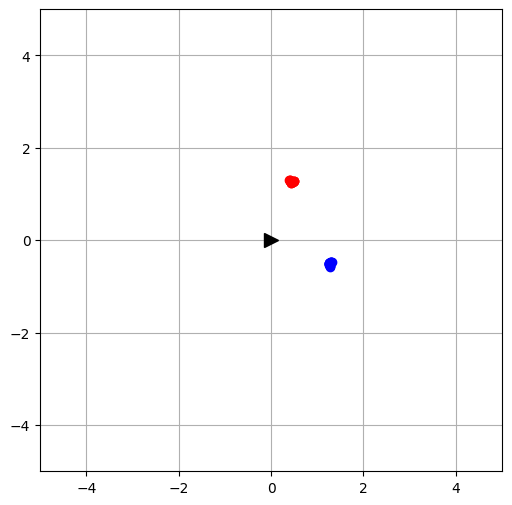

In [68]:
laserPlot(os.path.join(scenesFolder,"5/scene5.1.ttt"))

### 5.2
Para executar, abra a cena scene5.2.ttt na pasta 5 e rode a celula a seguir.

Connected to remote API server
Pos:  [1.9062512782094838, -5.999788488940047, 0.4386502067599916]
Program ended


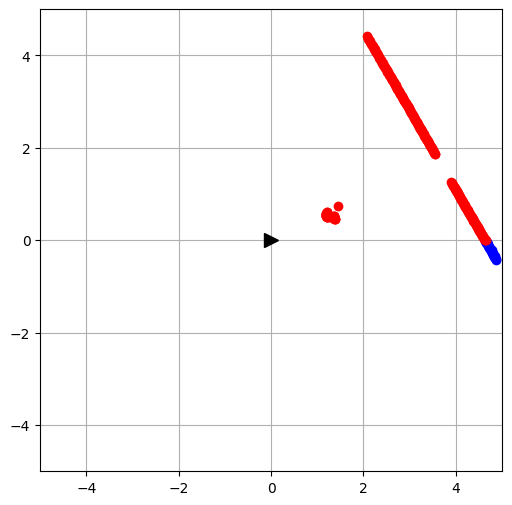

In [69]:
laserPlot(os.path.join(scenesFolder,"5/scene5.2.ttt"))

### 5.3
Para executar, abra a cena scene5.3.ttt na pasta 5 e rode a celula a seguir.

Connected to remote API server
Pos:  [-9.169349436769071, -0.6754502763396362, 0.4386501756067497]
Program ended


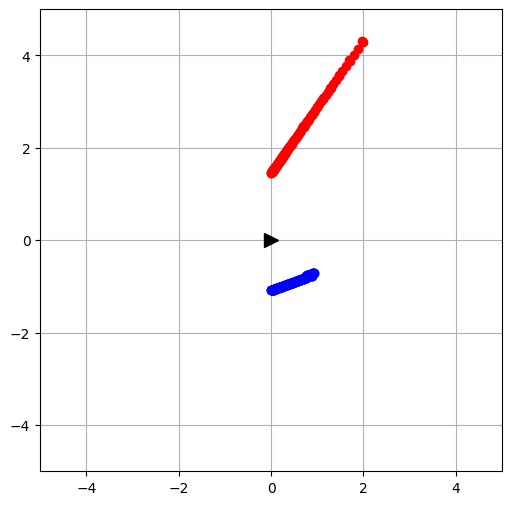

In [70]:
laserPlot(os.path.join(scenesFolder,"5/scene5.3.ttt"))

## Exercise 6
Para executar, selecione qualquer cena do exercício cinco

In [71]:
# selectedScene = "scene5.ttt"
# selectedScene = "scene5.1.ttt"
# selectedScene = "scene5.2.ttt"
selectedScene = "scene5.3.ttt"

In [72]:

def draw_laser_data_World_Ref(MTrans, laser_data, max_sensor_range=5, ax = None):
    
    if (ax == None):
        fig = plt.figure(figsize=(6,6), dpi=100)
        ax = fig.add_subplot(111, aspect='equal')
        
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
        # Logo, usar um pequeno limiar do máximo para considerar a leitura
        if (max_sensor_range - dist) > 0.1:
            p = np.zeros((4, 1))
            
            # Eixo x
            p[0] = dist * np.cos(ang)
            # Eixo y
            p[1] = dist * np.sin(ang)
            c = 'r'
            if ang < 0:    
                c = 'b'

            # Eixo Z, como é 2D o valor pode ser zero
            # p[2] = 0
            # Perspectiva
            p[3] = 1

            new_point = MTrans @ p

            ax.plot(new_point[0], new_point[1], 'o', color=c)

    ax.plot(0, 0, 'k>', markersize=10)

        
    ax.grid()
    # ax.set_xlim([-max_sensor_range, max_sensor_range])
    # ax.set_ylim([-max_sensor_range, max_sensor_range])

Connected to remote API server
Program ended


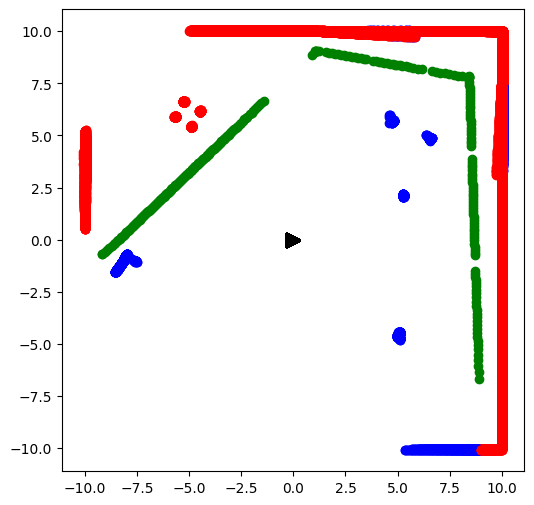

In [73]:
sim.loadScene(os.path.join(scenesFolder,"5", selectedScene)+"@keepCurrent")
sim.startSimulation()

print ('Connected to remote API server')
    
    
# Iniciando a simulação
# Deve usar a porta do 'continuous remote API server services' (remoteApiConnections.txt)
# e = sim.simxStartSimulation(clientID,sim.simx_opmode_blocking)

# Handle para o ROBÔ    
robotname = "/Pioneer_p3dx"
robotHandle = sim.getObject(robotname)     

# Handle para o Laser
lasername = "/Pioneer_p3dx/fastHokuyo"
laserHandle = sim.getObject(lasername)


# Handle para as juntas das RODAS
l_wheel = sim.getObject(robotname + '_leftMotor')
r_wheel = sim.getObject(robotname + '_rightMotor')    

#print(T_wl)

# Handle para os dados do LASER
laser_range_data = "hokuyo_range_data"
laser_angle_data = "hokuyo_angle_data"

# Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
# Em loop até garantir que as leituras serão válidas

range_data = None
while range_data == None:
    range_data = sim.getStringSignal(laser_range_data)
    # sim.step() responsável por sincronizar com a emulação
    sim.step()

# Prosseguindo com as leituras
raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
laser_data = np.array([raw_angle_data, raw_range_data]).T

#raise SystemExit()

# Dados do Pioneer
L = 0.381   # Metros
r = 0.0975  # Metros

###################################################

#        Maybe this part is the exercise 6

###################################################

fig = plt.figure(figsize=(6,6), dpi=100)
ax = fig.add_subplot(111, aspect='equal')
#ax1 = fig.add_subplot(122, aspect='equal')

t = 0
# Lembrar de habilitar o 'Real-time mode'
startTime=time.time()
lastTime = startTime
while t < 20:
    
    now = time.time()
    dt = now - lastTime

    # Fazendo leitura do laser   
    raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
    laser_data = np.array([raw_angle_data, raw_range_data]).T

    # Matriz de transformação do laser para o mundo
    ## Matrix de transformação laser para o robo
    T_rl = getTransformationMatrix(laserHandle, robotHandle)
    ## Matrix de transformação robo para o mundo
    T_rw = getTransformationMatrix(robotHandle)
    ## Matrix de transformaçao laser para o mundo
    T_wl = T_rw @ T_rl



    pos = sim.getObjectPosition(robotHandle, sim.handle_world)        
    # print('Pos: ', pos)

    ax.plot(pos[0], pos[1], 'o', color='g')

    draw_laser_data_World_Ref(T_wl, laser_data, ax = ax)
    # draw_laser_data(laser_data, ax = ax1)
    
    # Velocidade básica (linear, angular)
    v = 0
    w = np.deg2rad(0)      

    frente = int(len(laser_data)/2)
    lado_direito = int(len(laser_data)*1/4)
    lado_esquerdo = int(len(laser_data)*3/4)
    
    if laser_data[frente, 1] > 2:
        v = .5
        w = 0
    elif laser_data[lado_direito, 1] > 2:
        v = 0
        w = np.deg2rad(-30)
    elif laser_data[lado_esquerdo, 1] > 2:
        v = 0
        w = np.deg2rad(30)
    
    # Isso é o modelo cinemático, estudaremos detalhadamente depois!
    wl = v/r - (w*L)/(2*r)
    wr = v/r + (w*L)/(2*r)
    
    # Enviando velocidades
    sim.setJointTargetVelocity(l_wheel, wl)
    sim.setJointTargetVelocity(r_wheel, wr)        

    t = t + dt  
    lastTime = now

# Parando o robô    
sim.setJointTargetVelocity(r_wheel, 0)
sim.setJointTargetVelocity(l_wheel, 0)        
    
sim.stopSimulation()

print ('Program ended')